In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from collections import deque
import pandas as pd

# === Configuration Constants ===
ENV_SIZE = 2.0
NUM_SERVERS = 5
NUM_USERS = 10
SERVER_SPEEDS = np.array([1, 2, 4, 8, 10])
MAX_BUFFER_SIZE = 2          # Each user can buffer up to 2 unassigned tasks
TIME_STEP = 0.01              # Granularity of time for asynchronous simulation
SIM_DURATION = 1000           # Duration of simulation (seconds)

In [2]:
# === Task Object ===
class Task:
    """Task stores arrival, workload, and timing details."""
    def __init__(self, arrival_time, workload):
        self.arrival_time = arrival_time
        self.workload = workload
        self.assigned_time = None
        self.completion_time = None

In [3]:
# === Generate random 2D positions for servers and users ===
def generate_positions():
    return (np.random.uniform(0, ENV_SIZE, (NUM_SERVERS, 2)),
            np.random.uniform(0, ENV_SIZE, (NUM_USERS, 2)))

# === Compute distance-based and speed-based preference scores ===
def compute_preferences(users_pos, servers_pos):
    dist_matrix = cdist(users_pos, servers_pos)
    user_scores = 1.0 / ((5.0 / SERVER_SPEEDS) + dist_matrix / 5.0)
    user_prefs = np.argsort(-user_scores, axis=1)
    return dist_matrix, user_prefs

# === Generate Poisson-distributed arrival times ===
def generate_poisson_times(lam, duration):
    times = []
    t = 0
    while t < duration:
        t += np.random.exponential(1 / lam)
        if t < duration:
            times.append(t)
    return times

In [5]:
# === Asynchronous Simulation ===
def simulate_async(lam, duration, dist_matrix):
    server_queues = [[] for _ in range(NUM_SERVERS)]   # List of work queues per server
    user_buffers = [[] for _ in range(NUM_USERS)]      # Buffers for each user's pending tasks
    user_arrivals = [generate_poisson_times(lam, duration) for _ in range(NUM_USERS)]
    user_pending = [[] for _ in range(NUM_USERS)]      # Pending arrival queue per user

    # Create all tasks per user
    for u in range(NUM_USERS):
        for t in user_arrivals[u]:
            workload = np.random.exponential(5.0)
            user_pending[u].append((t, workload))

    completed_tasks = []

    def effective_speed(u, s):
        return 1.0 / ((5.0 / SERVER_SPEEDS[s]) + dist_matrix[u, s] / 5.0)

    # Main simulation loop
    for step in range(int(duration / TIME_STEP)):
        current_time = step * TIME_STEP

        # Update server queues (decrement task durations)
        for s in range(NUM_SERVERS):
            new_q = []
            for rem, arrival, workload, u in server_queues[s]:
                v = effective_speed(u, s)
                rem2 = rem - v * TIME_STEP
                if rem2 > 0:
                    new_q.append((rem2, arrival, workload, u))
                else:
                    # record true completion time
                    completion = current_time + rem / v
                    completed_tasks.append((arrival, workload, u, s, completion))
            server_queues[s] = new_q

        # Move any new arrivals to buffer
        for u in range(NUM_USERS):
            while user_pending[u] and user_pending[u][0][0] <= current_time:
                _, w = user_pending[u].pop(0)
                user_buffers[u].append((current_time, w))
                if len(user_buffers[u]) > MAX_BUFFER_SIZE:
                    user_buffers[u].pop(0)

        # Try to assign tasks from buffer
        for u in range(NUM_USERS):
            new_buffer = []
            for arrival, workload in user_buffers[u]:
                # Choose best server with capacity
                best_s = None
                best_score = -np.inf
                for s in range(NUM_SERVERS):
                    if len(server_queues[s]) < 1:                                       ## server capacity = 1
                        score = 1 / (5 / SERVER_SPEEDS[s] + dist_matrix[u][s] / 5)
                        if score > best_score:
                            best_score = score
                            best_s = s
                if best_s is not None:
                    server_queues[best_s].append((workload, arrival, workload, u))
                else:
                    new_buffer.append((arrival, workload))
            user_buffers[u] = new_buffer

    # Calculate average durations
    durations = [(completion - arrival)
                 for arrival, workload, u, s, completion in completed_tasks]
    return len(durations)/SIM_DURATION, np.mean(durations) if durations else np.nan

In [6]:
results = []
for env in range(10):
    servers_pos, users_pos = generate_positions()
    dist_matrix, user_prefs = compute_preferences(users_pos, servers_pos)

    for lam in range(1, 11):  # λ = 1 to 10
        async_tasks, async_time = simulate_async(lam, SIM_DURATION, dist_matrix)
        results.append({
                "lambda": lam,
                "async_tasks": async_tasks,
                "async_avg_time": async_time,
            })

# === Results as DataFrame ===
compare_df = pd.DataFrame(results)
lambda_means = compare_df.groupby("lambda").mean(numeric_only=True).reset_index()
print(lambda_means)


   lambda  async_tasks  async_avg_time
0       1       0.7570        7.733621
1       2       0.7695        7.233405
2       3       0.7464        7.258061
3       4       0.7654        6.923364
4       5       0.7541        6.953714
5       6       0.7622        6.838760
6       7       0.7591        6.805228
7       8       0.7565        6.825428
8       9       0.7515        6.867314
9      10       0.7453        6.875518


In [7]:
# === Synchronous Simulation ===
def simulate_sync(lam, slot_length, duration, dist_matrix, user_prefs):
    user_buffers = [[] for _ in range(NUM_USERS)]
    arrivals = []

    def effective_speed(u, s):
        return 1.0 / ((5.0 / SERVER_SPEEDS[s]) + dist_matrix[u, s] / 5.0)

    # Generate all task arrivals
    for u in range(NUM_USERS):
        for t in generate_poisson_times(lam, duration):
            workload = np.random.exponential(5.0)
            arrivals.append((t, u, workload))
    arrivals.sort()

    # Server queue setup
    arrival_index = 0
    current_time = 0
    server_tasks = [[] for _ in range(NUM_SERVERS)]
    completion_times = []

    # Main loop over slots
    while current_time < duration:
        # Update server queues
        for s in range(NUM_SERVERS):
            updated = []
            for remaining, task, u in server_tasks[s]:
                v = effective_speed(u, s)
                worked = v * slot_length
                if remaining - worked > 0:
                    updated.append((remaining - worked, task, u))
                else:
                    task.completion_time = current_time + task.workload / v
                    completion_times.append(task.completion_time - task.arrival_time)
            server_tasks[s] = updated

        # Add new arrivals to user buffers
        while arrival_index < len(arrivals) and arrivals[arrival_index][0] < current_time + slot_length:
            t, u, w = arrivals[arrival_index]
            task = Task(t, w)
            user_buffers[u].append(task)
            if len(user_buffers[u]) > MAX_BUFFER_SIZE:
                user_buffers[u].pop(0)
            arrival_index += 1

        # Compute remaining server capacities
        capacity = [max(0, 1 - len(server_tasks[s])) for s in range(NUM_SERVERS)]

        # === Many-to-One Stable Matching ===
        free_users = deque([u for u in range(NUM_USERS) if user_buffers[u]])
        proposals = np.zeros((NUM_USERS, NUM_SERVERS), dtype=bool)
        server_matches = {s: [] for s in range(NUM_SERVERS)}

        server_rank = np.full((NUM_SERVERS, NUM_USERS), np.inf)
        for s in range(NUM_SERVERS):
            sorted_users = np.argsort(dist_matrix[:, s])
            for rank, u in enumerate(sorted_users):
                server_rank[s, u] = rank

        while free_users:
            u = free_users.popleft()
            for s in user_prefs[u]:
                if not proposals[u, s]:
                    proposals[u, s] = True
                    server_matches[s].append(u)
                    break
            for s in range(NUM_SERVERS):
                if len(server_matches[s]) > capacity[s]:
                    sorted_users = sorted(server_matches[s], key=lambda x: server_rank[s][x])
                    server_matches[s] = sorted_users[:capacity[s]]
                    for rej_u in sorted_users[capacity[s]:]:
                        free_users.append(rej_u)

        # Assign matched users to servers
        for s, users in server_matches.items():
            for u in users:
                task = user_buffers[u].pop(0)
                task.assigned_time = current_time
                server_tasks[s].append((task.workload, task, u))

        current_time += slot_length

    return len(completion_times)/duration, np.mean(completion_times) if completion_times else np.nan

In [8]:
# === Compare Over 10 Random Environments ===
results = []
for env in range(10):
    servers_pos, users_pos = generate_positions()
    dist_matrix, user_prefs = compute_preferences(users_pos, servers_pos)

    for lam in range(1, 11):  # λ = 1 to 10
        async_tasks, async_time = simulate_async(lam, SIM_DURATION, dist_matrix)

        for L in range(1, 11):  # Slot length L = 1 to 10
            sync_tasks, sync_time = simulate_sync(lam, L, SIM_DURATION, dist_matrix, user_prefs)
            results.append({
                "env": env,
                "lambda": lam,
                "slot_length": L,
                "async_tasks": async_tasks,
                "async_avg_time": async_time,
                "sync_tasks": sync_tasks,
                "sync_avg_time": sync_time
            })

# === Results as DataFrame ===
compare_df = pd.DataFrame(results)

print(compare_df)

     env  lambda  slot_length  async_tasks  async_avg_time  sync_tasks  \
0      0       1            1        0.741        7.966150       0.746   
1      0       1            2        0.741        7.966150       0.667   
2      0       1            3        0.741        7.966150       0.612   
3      0       1            4        0.741        7.966150       0.540   
4      0       1            5        0.741        7.966150       0.511   
..   ...     ...          ...          ...             ...         ...   
995    9      10            6        0.848        6.007589       0.484   
996    9      10            7        0.848        6.007589       0.424   
997    9      10            8        0.848        6.007589       0.412   
998    9      10            9        0.848        6.007589       0.374   
999    9      10           10        0.848        6.007589       0.348   

     sync_avg_time  
0        13.594710  
1        13.410922  
2        13.284521  
3        13.948099  
4     

#full buffer duo to low speed

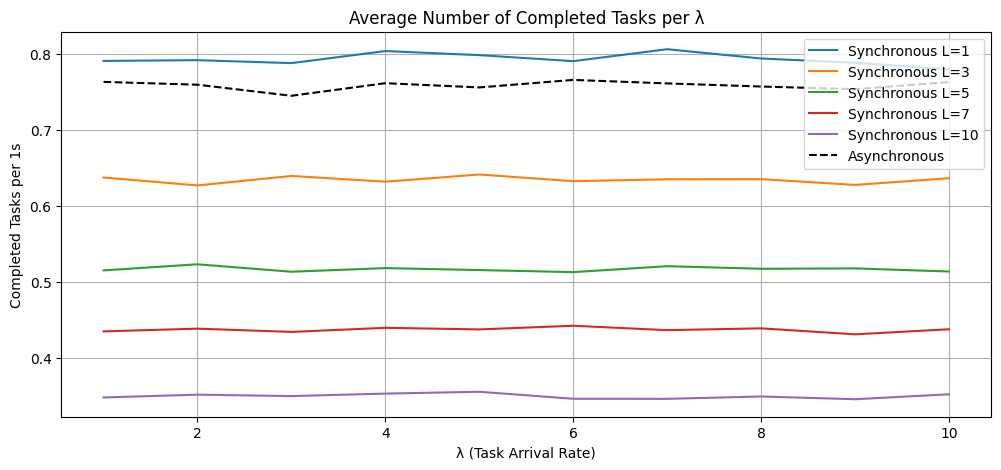

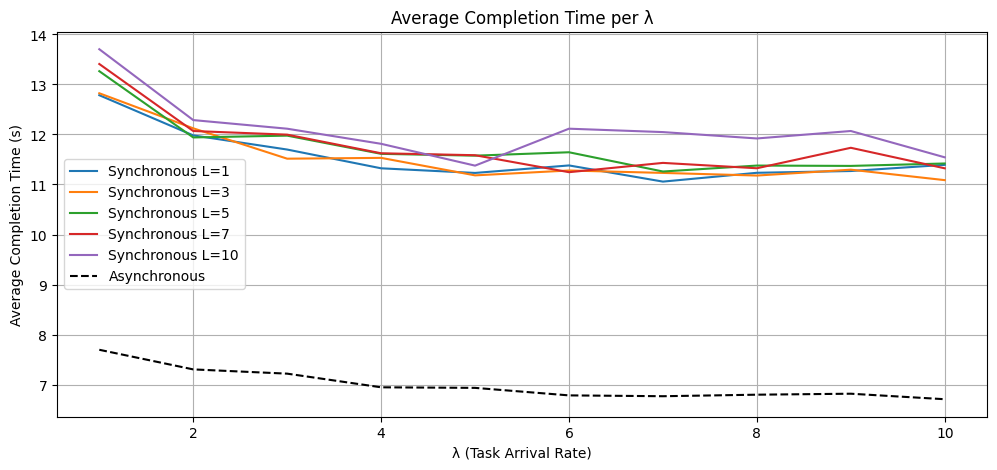

   lambda  best_L_by_tasks  sync_tasks  best_L_by_time  sync_avg_time
0       1                1       0.844               1      11.943488
1       2                1       0.832               6      10.668942
2       3                1       0.831               7      10.200828
3       4                1       0.842               3      10.528476
4       5                1       0.892               1       9.918180
5       6                1       0.839               7      10.236496
6       7                1       0.846               9       9.826140
7       8                1       0.862               6       9.634050
8       9                1       0.814               9      10.261466
9      10                1       0.855               7      10.037672


In [9]:
import matplotlib.pyplot as plt

# === Summarize best slot length for each λ based on:
# (a) Maximum number of sync tasks
# (b) Minimum average completion time

best_L_throughput = compare_df.loc[compare_df.groupby("lambda")["sync_tasks"].idxmax()][
    ["lambda", "slot_length", "sync_tasks"]
].rename(columns={"slot_length": "best_L_by_tasks"})

best_L_time = compare_df.loc[compare_df.groupby("lambda")["sync_avg_time"].idxmin()][
    ["lambda", "slot_length", "sync_avg_time"]
].rename(columns={"slot_length": "best_L_by_time"})

summary_df = pd.merge(best_L_throughput, best_L_time, on="lambda")

# === Plot Performance: Synchronous vs Asynchronous ===
avg_df = compare_df.groupby(["lambda", "slot_length"]).agg({
    "sync_tasks": "mean",
    "sync_avg_time": "mean"
}).reset_index()

async_avg = compare_df.groupby("lambda").agg({
    "async_tasks": "mean",
    "async_avg_time": "mean"
}).reset_index()

# Plot: Number of Calculations per Unit Time
plt.figure(figsize=(12, 5))
for L in [1, 3, 5, 7, 10]:
    plt.plot(avg_df[avg_df.slot_length == L]["lambda"], avg_df[avg_df.slot_length == L]["sync_tasks"],
             label=f"Synchronous L={L}")
plt.plot(async_avg["lambda"], async_avg["async_tasks"], label="Asynchronous", linestyle="--", color="black")
plt.title("Average Number of Completed Tasks per λ")
plt.xlabel("λ (Task Arrival Rate)")
plt.ylabel("Completed Tasks per 1s")
plt.legend()
plt.grid(True)
plt.show()

# Plot: Average Completion Time
plt.figure(figsize=(12, 5))
for L in [1, 3, 5, 7, 10]:
    plt.plot(avg_df[avg_df.slot_length == L]["lambda"], avg_df[avg_df.slot_length == L]["sync_avg_time"],
             label=f"Synchronous L={L}")
plt.plot(async_avg["lambda"], async_avg["async_avg_time"], label="Asynchronous", linestyle="--", color="black")
plt.title("Average Completion Time per λ")
plt.xlabel("λ (Task Arrival Rate)")
plt.ylabel("Average Completion Time (s)")
plt.legend()
plt.grid(True)
plt.show()

print(summary_df)